## Imports

In [ ]:
# ========== 📦 INSTALL DEPENDENCIES (Colab only) ==========
!pip install -q sentence-transformers xgboost shap seaborn scikit-learn

# ========== 📚 PYTHON LIBRARIES ==========
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 📊 ML + NLP ==========
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

# ========== 📈 EXPLAINABILITY ==========
import shap

# ========== 📦 IPYWIDGETS (for UI in Jupyter/Colab) ==========
from ipywidgets import Combobox, Checkbox, Button, VBox, HBox, Output, SelectMultiple, FloatSlider, interact
from IPython.display import display, clear_output

# ========== 🧠 NLTK ==========
import nltk
from nltk.corpus import stopwords

In [ ]:
# Load both datasets
df_jobs = pd.read_csv('/content/df_small.csv')
df_candidates = pd.read_csv('/content/new_df.csv')
new_df = pd.read_csv('/content/new_df.csv')

In [ ]:

# Fill NA in experience columns
df_jobs['Experience_Min'] = df_jobs['Experience_Min'].fillna(0)
df_jobs['Experience_Max'] = df_jobs['Experience_Max'].fillna(df_jobs['Experience_Min'] + 5)
df_candidates['experiencere'] = df_candidates['experiencere'].fillna(0)

# Take a sample (or all if small)
sample_jobs = df_jobs.sample(200, random_state=42)
sample_candidates = df_candidates.sample(200, random_state=42)

# Define experience scoring function
def experience_score(candidate_exp, min_exp, max_exp, margin=2.0):
    if min_exp <= candidate_exp <= max_exp:
        return 1.0
    elif candidate_exp < min_exp:
        return max(0, 1 - (min_exp - candidate_exp) / margin)
    else:  # candidate_exp > max_exp
        return max(0, 1 - (candidate_exp - max_exp) / margin)

# Apply experience scoring to candidate–job pairs
experience_scores = []

for _, job in sample_jobs.iterrows():
    for _, cand in sample_candidates.iterrows():
        score = experience_score(cand['experiencere'], job['Experience_Min'], job['Experience_Max'])
        experience_scores.append({
            'Job_Id': job['Job Id'],
            'Candidate_Id': cand['Unnamed: 0'],
            'Experience_Score': score
        })

# Convert to DataFrame
exp_score_df = pd.DataFrame(experience_scores)

# Show a few results
exp_score_df


,Job_Id,Candidate_Id,Experience_Score
0,1198499152631869,248,1.0
1,1198499152631869,2165,1.0
2,1198499152631869,6847,1.0
3,1198499152631869,4812,0.0
4,1198499152631869,2157,1.0
...,...,...,...
39995,1056919742001144,5687,1.0
39996,1056919742001144,1071,1.0
39997,1056919742001144,2870,1.0
39998,1056919742001144,7452,0.0


In [ ]:
# Clean and parse fields
def clean_list(val):
    try:
        return [x.strip().lower() for x in ast.literal_eval(val) if isinstance(x, str)]
    except:
        return []

df_candidates['major_field_of_studies_clean'] = df_candidates['major_field_of_studies'].apply(clean_list)
df_jobs['Recommended_Study_Field_clean'] = df_jobs['Recommended_Study_Field'].fillna("").str.lower()

# Sample for pairing
sample_jobs = df_jobs.sample(200, random_state=42)
sample_cands = df_candidates.sample(200, random_state=42)

# Matching function with token overlap
def field_match(candidate_fields, job_field_text):
    job_tokens = set(job_field_text.replace(",", " ").split())
    job_tokens = {token.strip().lower() for token in job_tokens if token}

    for field in candidate_fields:
        field_words = field.split()
        for word in field_words:
            if word in job_tokens:
                return 1
    return 0

# Collect match data with fields and score
field_match_data = []

for _, job in sample_jobs.iterrows():
    for _, cand in sample_cands.iterrows():
        score = field_match(cand['major_field_of_studies_clean'], job['Recommended_Study_Field_clean'])
        field_match_data.append({
            'Job_Id': job['Job Id'],
            'Candidate_Id': cand['Unnamed: 0'],
            'Recommended_Field': job['Recommended_Study_Field_clean'],
            'Candidate_Fields': cand['major_field_of_studies_clean'],
            'field_match_score': score
        })

field_score_df = pd.DataFrame(field_match_data) # Added this line

# Filter to show only matches (score == 1)
matched_df = field_score_df[field_score_df['field_match_score'] == 1]

# Show the top 10 matches
matched_df


,Job_Id,Candidate_Id,Recommended_Field,Candidate_Fields,field_match_score
50,1198499152631869,4379,"marketing, communication",[communication],1
121,1198499152631869,8057,"marketing, communication","[computer science, electronics and communicati...",1
181,1198499152631869,7963,"marketing, communication",[electronics and communication],1
186,1198499152631869,1349,"marketing, communication","[coaching, business administration, marketing]",1
213,259454610846951,7468,"computer science, software engineering","[computer science, computer science]",1
...,...,...,...,...,...
39960,1056919742001144,5062,aerospace engineering,"[mathematics, physics, chemistry, engineering,...",1
39966,1056919742001144,1429,aerospace engineering,"[petrochemical and natural gas engineering, bi...",1
39967,1056919742001144,774,aerospace engineering,"[control systems, electrical engineering, mach...",1
39968,1056919742001144,2968,aerospace engineering,"[mechanical engineering, electrical engineerin...",1


In [ ]:
# Clean and convert field lists to strings
def clean_list(val):
    try:
        return " ".join([x.strip() for x in ast.literal_eval(val) if isinstance(x, str)])
    except:
        return ""

df_candidates['Candidate_Field_Text'] = df_candidates['major_field_of_studies'].apply(clean_list)
df_jobs['Recommended_Field_Text'] = df_jobs['Recommended_Study_Field'].fillna("")

# Sample
sample_jobs = df_jobs.sample(200, random_state=42).reset_index(drop=True)
sample_cands = df_candidates.sample(200, random_state=42).reset_index(drop=True)

# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed all job and candidate fields at once
job_embeds = model.encode(sample_jobs['Recommended_Field_Text'].tolist(), convert_to_tensor=False)
cand_embeds = model.encode(sample_cands['Candidate_Field_Text'].tolist(), convert_to_tensor=False)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(job_embeds, cand_embeds)

# Flatten to long DataFrame format
job_ids = sample_jobs['Job Id']
cand_ids = sample_cands['Unnamed: 0']
job_fields = sample_jobs['Recommended_Field_Text']
cand_fields = sample_cands['Candidate_Field_Text']

rows = []
for i in range(len(job_ids)):
    for j in range(len(cand_ids)):
        rows.append({
            'Job_Id': job_ids[i],
            'Candidate_Id': cand_ids[j],
            'Recommended_Field': job_fields[i],
            'Candidate_Fields': cand_fields[j],
            'bert_field_similarity': similarity_matrix[i, j]
        })

bert_score_df = pd.DataFrame(rows)

# Show top 10 highest scoring matches
bert_score_df.sort_values(by='bert_field_similarity', ascending=False)


,Job_Id,Candidate_Id,Recommended_Field,Candidate_Fields,bert_field_similarity
28900,42696056723316,5403,Information Technology,Information Technology,1.000000
28997,42696056723316,2870,Information Technology,Information Technology,1.000000
28877,42696056723316,7088,Information Technology,Information Technology,1.000000
28914,42696056723316,2718,Information Technology,Information Technology,1.000000
8700,1086530742535682,5403,Information Technology,Information Technology,1.000000
...,...,...,...,...,...
3167,1498319094221445,774,"English, Journalism",Control Systems Electrical Engineering Machine...,-0.076033
3049,1498319094221445,7153,"English, Journalism",Control Systems Electrical Engineering Machine...,-0.076033
4649,1675672351150416,7153,"English, Journalism",Control Systems Electrical Engineering Machine...,-0.076033
4767,1675672351150416,774,"English, Journalism",Control Systems Electrical Engineering Machine...,-0.076033


In [ ]:
# Clean major_field_of_studies column before processing
def is_valid_field(val):
    try:
        items = ast.literal_eval(val)
        if not items:
            return False
        cleaned = [x.strip().lower() for x in items if isinstance(x, str)]
        return all(f not in ["n/a", "none", ""] for f in cleaned)
    except:
        return False

# Filter both datasets
df_candidates = df_candidates[df_candidates['major_field_of_studies'].apply(is_valid_field)].copy()
df_jobs = df_jobs[df_jobs['Recommended_Study_Field'].notna() & (df_jobs['Recommended_Study_Field'].str.strip() != "")].copy()


In [ ]:
# Clean major_field_of_studies column before processing
def is_valid_field(val):
    try:
        items = ast.literal_eval(val)
        if not items:
            return False
        cleaned = [x.strip().lower() for x in items if isinstance(x, str)]
        return all(f not in ["n/a", "none", ""] for f in cleaned)
    except:
        return False

# Filter both datasets
df_candidates = df_candidates[df_candidates['major_field_of_studies'].apply(is_valid_field)].copy()
df_jobs = df_jobs[df_jobs['Recommended_Study_Field'].notna() & (df_jobs['Recommended_Study_Field'].str.strip() != "")].copy()

# Clean candidate fields (join list to sentence)
def clean_field_list(val):
    try:
        return " ".join([x.strip() for x in ast.literal_eval(val) if isinstance(x, str)])
    except:
        return ""

df_candidates['major_field_of_studies_clean'] = df_candidates['major_field_of_studies'].apply(clean_field_list)
df_jobs['Recommended_Study_Field_clean'] = df_jobs['Recommended_Study_Field'].fillna("")

# Sample
sample_jobs = df_jobs.sample(200, random_state=42).reset_index(drop=True)
sample_cands = df_candidates.sample(200, random_state=42).reset_index(drop=True)

# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed fields
job_embeds = model.encode(sample_jobs['Recommended_Study_Field_clean'].tolist(), convert_to_tensor=False)
cand_embeds = model.encode(sample_cands['major_field_of_studies_clean'].tolist(), convert_to_tensor=False)

# Cosine similarity matrix
similarity_matrix = cosine_similarity(job_embeds, cand_embeds)

# Flatten matrix to long format
rows = []
for i in range(len(sample_jobs)):
    for j in range(len(sample_cands)):
        rows.append({
            'Job_Id': sample_jobs.loc[i, 'Job Id'],
            'Candidate_Id': sample_cands.loc[j, 'Unnamed: 0'],
            'major_field_of_studies': sample_cands.iloc[j]['major_field_of_studies'],
            'Recommended_Study_Field': sample_jobs.iloc[i]['Recommended_Study_Field'],

            'bert_field_similarity': similarity_matrix[i, j]
        })

bert_field_df = pd.DataFrame(rows)

# Show top results
bert_field_df.sort_values(by='bert_field_similarity', ascending=False)


,Job_Id,Candidate_Id,major_field_of_studies,Recommended_Study_Field,bert_field_similarity
7172,1333362768960248,3485,['Mechanical Engineering'],Mechanical Engineering,1.000000
7126,1333362768960248,5873,"['Mechanical Engineering', None]",Mechanical Engineering,1.000000
7124,1333362768960248,148,['Mechanical Engineering'],Mechanical Engineering,1.000000
7090,1333362768960248,6183,['Mechanical Engineering'],Mechanical Engineering,1.000000
7191,1333362768960248,6812,['Mechanical Engineering'],Mechanical Engineering,1.000000
...,...,...,...,...,...
23468,806961037669820,1220,"['Finance', 'Economics & Finance']",Landscape Architecture,-0.047401
23475,806961037669820,5472,"['Finance', 'Economics & Finance']",Landscape Architecture,-0.047401
15469,558335297710295,3995,"['Finance', 'Economics & Finance']",Landscape Architecture,-0.047401
15475,558335297710295,5472,"['Finance', 'Economics & Finance']",Landscape Architecture,-0.047401


In [ ]:
# Job: convert 'skills_tokenized' string to list
def parse_skill_list(val):
    try:
        return [x.strip().lower() for x in ast.literal_eval(val)]
    except:
        return []

# Candidate: split raw skills string into tokens
def split_candidate_skills(text):
    try:
        return [x.strip().lower() for x in text.split()]
    except:
        return []

df_jobs['skills_tokenized_clean'] = df_jobs['skills_tokenized'].apply(parse_skill_list)
df_candidates['skills_clean'] = df_candidates['skills'].fillna("").astype(str).apply(split_candidate_skills)

# Function to create 2-grams (bigrams)
def create_bigrams(tokens):
    return [" ".join([tokens[i], tokens[i + 1]]) for i in range(len(tokens) - 1)]

df_jobs['skills_bigrams'] = df_jobs['skills_tokenized_clean'].apply(create_bigrams)
df_candidates['skills_bigrams'] = df_candidates['skills_clean'].apply(create_bigrams)

# Sample
sample_jobs = df_jobs.sample(200, random_state=42).reset_index(drop=True)
sample_cands = df_candidates.sample(200, random_state=42).reset_index(drop=True)

# Jaccard similarity function
def jaccard_similarity(set1, set2):
    set1, set2 = set(set1), set(set2)
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)

# Build pairwise score dataset
skills_ngram_data = []

for i in range(len(sample_jobs)):
    for j in range(len(sample_cands)):
        job_ngrams = sample_jobs.iloc[i]['skills_bigrams']
        cand_ngrams = sample_cands.iloc[j]['skills_bigrams']
        score = jaccard_similarity(job_ngrams, cand_ngrams)

        skills_ngram_data.append({
            'Job_Id': sample_jobs.iloc[i]['Job Id'],
            'Candidate_Id': sample_cands.iloc[j]['Unnamed: 0'],
            'Job_Title': sample_jobs.iloc[i]['Job Title'],
            'Job_Skills_Bigrams': job_ngrams,
            'Candidate_Skills_Bigrams': cand_ngrams,
            'skills_bigram_score': score
        })

# Create DataFrame
skills_bigram_df = pd.DataFrame(skills_ngram_data)

# Show top 10 matched pairs
skills_bigram_df.sort_values(by='skills_bigram_score', ascending=False).head(10)


,Job_Id,Candidate_Id,Job_Title,Job_Skills_Bigrams,Candidate_Skills_Bigrams,skills_bigram_score
27450,2647023393471757,3751,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[data analysis, analysis data, data visualizat...",0.136364
27455,2647023393471757,4730,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[machine learning, learning artificial, artifi...",0.125000
27405,2647023393471757,6881,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[machine learning, learning artificial, artifi...",0.125000
27417,2647023393471757,4821,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[data analysis, analysis data, data analytics,...",0.111111
27459,2647023393471757,2927,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[data analysis, analysis data, data analytics,...",0.111111
27445,2647023393471757,862,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[data science, science data, data analysis, an...",0.107143
24969,1581812090685055,1212,Sales Manager,"[sales strategy, strategy development, develop...","[key decision, decision making, making marketi...",0.102564
24892,1581812090685055,3053,Sales Manager,"[sales strategy, strategy development, develop...","[key decision, decision making, making marketi...",0.102564
27429,2647023393471757,8177,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[data analysis, analysis data, data analytics,...",0.090909
27551,2647023393471757,8178,Marketing Specialist,"[marketing analytics, analytics data, data ana...","[data analysis, analysis data, data analytics,...",0.090909


In [ ]:

# Download stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean + tokenize (remove stop words)
def parse_job_skills(val):
    try:
        tokens = [x.strip().lower() for x in ast.literal_eval(val)]
        return [t for t in tokens if t not in stop_words]
    except:
        return []

def parse_candidate_skills(val):
    try:
        tokens = [x.strip().lower() for x in val.split()]
        return [t for t in tokens if t not in stop_words]
    except:
        return []

# Generate n-grams
def get_ngrams(tokens):
    unigrams = tokens
    bigrams = [" ".join([tokens[i], tokens[i + 1]]) for i in range(len(tokens) - 1)]
    return unigrams + bigrams

# Apply
df_jobs['skills_tokens'] = df_jobs['skills_tokenized'].apply(parse_job_skills)
df_candidates['skills_tokens'] = df_candidates['skills'].fillna("").astype(str).apply(parse_candidate_skills)

df_jobs['job_ngrams'] = df_jobs['skills_tokens'].apply(get_ngrams)
df_candidates['cand_ngrams'] = df_candidates['skills_tokens'].apply(get_ngrams)

# Sample
sample_jobs = df_jobs.sample(200, random_state=42).reset_index(drop=True)
sample_cands = df_candidates.sample(200, random_state=42).reset_index(drop=True)

# Normalized skill score: (# matched n-grams) / (# job n-grams)
def skill_ngram_score(job_ngrams, cand_ngrams):
    job_set = set(job_ngrams)
    cand_set = set(cand_ngrams)
    if not job_set:
        return 0.0
    match_count = len(job_set & cand_set)
    return match_count / len(job_set)

# Score all pairs
combined_skill_scores = []

for i in range(len(sample_jobs)):
    for j in range(len(sample_cands)):
        job_ngrams = sample_jobs.iloc[i]['job_ngrams']
        cand_ngrams = sample_cands.iloc[j]['cand_ngrams']
        score = skill_ngram_score(job_ngrams, cand_ngrams)

        combined_skill_scores.append({
            'Job_Id': sample_jobs.iloc[i]['Job Id'],
            'Candidate_Id': sample_cands.iloc[j]['Unnamed: 0'],
            'Job_Title': sample_jobs.iloc[i]['Job Title'],
            'Job_Ngrams': job_ngrams,
            'Candidate_Ngrams': cand_ngrams,
            'normalized_skill_score': score
        })

# Create final DataFrame
final_skill_df = pd.DataFrame(combined_skill_scores)

# Show top matches
final_skill_df.sort_values(by='normalized_skill_score', ascending=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Job_Id,Candidate_Id,Job_Title,Job_Ngrams,Candidate_Ngrams,normalized_skill_score
24892,1581812090685055,3053,Sales Manager,"[sales, strategy, development, territory, mana...","[key, decision, making, marketing, verbal, wri...",0.714286
24969,1581812090685055,1212,Sales Manager,"[sales, strategy, development, territory, mana...","[key, decision, making, marketing, verbal, wri...",0.714286
37692,179750567988041,3053,Sales Manager,"[key, account, management, relationship, build...","[key, decision, making, marketing, verbal, wri...",0.615385
9569,571808364580824,1212,Sales Manager,"[key, account, management, relationship, build...","[key, decision, making, marketing, verbal, wri...",0.615385
37769,179750567988041,1212,Sales Manager,"[key, account, management, relationship, build...","[key, decision, making, marketing, verbal, wri...",0.615385
...,...,...,...,...,...,...
23906,2867897247385936,3908,Network Engineer,"[wireless, network, design, architecture, wi, ...","[fas, asset, accounting, quickbooks, anytime, ...",0.000000
23905,2867897247385936,7384,Network Engineer,"[wireless, network, design, architecture, wi, ...","[python, mysql, tensorflow, keras, machine, le...",0.000000
23904,2867897247385936,5127,Network Engineer,"[wireless, network, design, architecture, wi, ...","[machine, learning, engineering, algorithm, de...",0.000000
23903,2867897247385936,7935,Network Engineer,"[wireless, network, design, architecture, wi, ...","[deep, learning, python, sql, keras, pytorch, ...",0.000000


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ========== LOAD ==========
df_jobs = pd.read_csv('/content/df_small.csv')
df_candidates = pd.read_csv('/content/new_df.csv')

# ========== EXPERIENCE SCORE ==========
df_jobs['Experience_Min'] = df_jobs['Experience_Min'].fillna(0)
df_jobs['Experience_Max'] = df_jobs['Experience_Max'].fillna(df_jobs['Experience_Min'] + 5)
df_candidates['experiencere'] = df_candidates['experiencere'].fillna(0)

sample_jobs = df_jobs.sample(200, random_state=42)
sample_candidates = df_candidates.sample(200, random_state=42)

def experience_score(candidate_exp, min_exp, max_exp, margin=2.0):
    if min_exp <= candidate_exp <= max_exp:
        return 1.0
    elif candidate_exp < min_exp:
        return max(0, 1 - (min_exp - candidate_exp) / margin)
    else:
        return max(0, 1 - (candidate_exp - max_exp) / margin)

experience_scores = []
for _, job in sample_jobs.iterrows():
    for _, cand in sample_candidates.iterrows():
        score = experience_score(cand['experiencere'], job['Experience_Min'], job['Experience_Max'])
        experience_scores.append({
            'Job_Id': job['Job Id'],
            'Candidate_Id': cand['Unnamed: 0'],
            'Experience_Score': score
        })
exp_score_df = pd.DataFrame(experience_scores)

# ========== BERT FIELD SIMILARITY ==========
def is_valid_field(val):
    try:
        items = ast.literal_eval(val)
        if not items:
            return False
        cleaned = [x.strip().lower() for x in items if isinstance(x, str)]
        return all(f not in ["n/a", "none", ""] for f in cleaned)
    except:
        return False

df_candidates = df_candidates[df_candidates['major_field_of_studies'].apply(is_valid_field)].copy()
df_jobs = df_jobs[df_jobs['Recommended_Study_Field'].notna() & (df_jobs['Recommended_Study_Field'].str.strip() != "")].copy()

def clean_field_list(val):
    try:
        return " ".join([x.strip() for x in ast.literal_eval(val) if isinstance(x, str)])
    except:
        return ""

df_candidates['major_field_of_studies_clean'] = df_candidates['major_field_of_studies'].apply(clean_field_list)
df_jobs['Recommended_Study_Field_clean'] = df_jobs['Recommended_Study_Field'].fillna("")

sample_jobs = df_jobs.sample(200, random_state=42).reset_index(drop=True)
sample_cands = df_candidates.sample(200, random_state=42).reset_index(drop=True)

model = SentenceTransformer('all-MiniLM-L6-v2')
job_embeds = model.encode(sample_jobs['Recommended_Study_Field_clean'].tolist(), convert_to_tensor=False)
cand_embeds = model.encode(sample_cands['major_field_of_studies_clean'].tolist(), convert_to_tensor=False)

similarity_matrix = cosine_similarity(job_embeds, cand_embeds)
bert_rows = []
for i in range(len(sample_jobs)):
    for j in range(len(sample_cands)):
        bert_rows.append({
            'Job_Id': sample_jobs.loc[i, 'Job Id'],
            'Candidate_Id': sample_cands.loc[j, 'Unnamed: 0'],
            'bert_field_similarity': similarity_matrix[i, j]
        })
bert_field_df = pd.DataFrame(bert_rows)

# ========== SKILL N-GRAM SCORE ==========
def parse_job_skills(val):
    try:
        tokens = [x.strip().lower() for x in ast.literal_eval(val)]
        return [t for t in tokens if t not in stop_words]
    except:
        return []

def parse_candidate_skills(val):
    try:
        tokens = [x.strip().lower() for x in val.split()]
        return [t for t in tokens if t not in stop_words]
    except:
        return []

def get_ngrams(tokens):
    unigrams = tokens
    bigrams = [" ".join([tokens[i], tokens[i + 1]]) for i in range(len(tokens) - 1)]
    return unigrams + bigrams

df_jobs['skills_tokens'] = df_jobs['skills_tokenized'].apply(parse_job_skills)
df_candidates['skills_tokens'] = df_candidates['skills'].fillna("").astype(str).apply(parse_candidate_skills)
df_jobs['job_ngrams'] = df_jobs['skills_tokens'].apply(get_ngrams)
df_candidates['cand_ngrams'] = df_candidates['skills_tokens'].apply(get_ngrams)

sample_jobs = df_jobs.sample(200, random_state=42).reset_index(drop=True)
sample_cands = df_candidates.sample(200, random_state=42).reset_index(drop=True)

def skill_ngram_score(job_ngrams, cand_ngrams):
    job_set = set(job_ngrams)
    cand_set = set(cand_ngrams)
    if not job_set:
        return 0.0
    match_count = len(job_set & cand_set)
    return match_count / len(job_set)

combined_skill_scores = []
for i in range(len(sample_jobs)):
    for j in range(len(sample_cands)):
        job_ngrams = sample_jobs.iloc[i]['job_ngrams']
        cand_ngrams = sample_cands.iloc[j]['cand_ngrams']
        score = skill_ngram_score(job_ngrams, cand_ngrams)
        combined_skill_scores.append({
            'Job_Id': sample_jobs.iloc[i]['Job Id'],
            'Candidate_Id': sample_cands.iloc[j]['Unnamed: 0'],
            'normalized_skill_score': score
        })
final_skill_df = pd.DataFrame(combined_skill_scores)

# ========== MERGE ALL ==========
# Ensure IDs are strings
exp_score_df['Job_Id'] = exp_score_df['Job_Id'].astype(str)
exp_score_df['Candidate_Id'] = exp_score_df['Candidate_Id'].astype(str)
bert_field_df['Job_Id'] = bert_field_df['Job_Id'].astype(str)
bert_field_df['Candidate_Id'] = bert_field_df['Candidate_Id'].astype(str)
final_skill_df['Job_Id'] = final_skill_df['Job_Id'].astype(str)
final_skill_df['Candidate_Id'] = final_skill_df['Candidate_Id'].astype(str)

# Merge all scores
merged_df = (
    exp_score_df
    .merge(bert_field_df, on=['Job_Id', 'Candidate_Id'], how='inner')
    .merge(final_skill_df, on=['Job_Id', 'Candidate_Id'], how='inner')
)

# Show result
print("✅ Merged data ready for modeling:")
merged_df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Merged data ready for modeling:


,Job_Id,Candidate_Id,Experience_Score,bert_field_similarity,normalized_skill_score
0,2233815434784640,1180,1.0,0.141511,0.000000
1,2233815434784640,6109,1.0,0.219836,0.000000
2,2233815434784640,2948,0.0,0.085258,0.019231
3,2233815434784640,360,0.0,0.241255,0.019231
4,545037330114622,1180,1.0,0.375479,0.000000
5,545037330114622,6109,1.0,0.375715,0.000000
6,545037330114622,2948,0.0,0.214567,0.000000
7,545037330114622,360,0.0,0.240861,0.066667
8,979981965008797,1180,1.0,0.300013,0.000000
9,979981965008797,6109,1.0,0.292496,0.000000


In [ ]:
merged_df.to_csv('/content/merged_data.csv', index=False)

In [ ]:
# 📁 Load your merged dataset
merged_df = pd.read_csv('/content/merged_data.csv')

## Oversampling (Smote)

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('merged_data.csv')


# Create 'skills_label' based only on 'normalized_skill_score'
# New threshold: label as 1 if skill score >= 0.2, else 0
df['skills_label'] = ((df['Experience_Score'] + df['normalized_skill_score'] ) /2 >= 0.4).astype(int)

# Create 'field_exp_label' based on Experience and BERT similarity
df['field_exp_label'] = (df['bert_field_similarity'] >=0.085258).astype(int)

# Save or view the result
df.to_csv('labeled_data.csv', index=False)
df[['normalized_skill_score', 'skills_label', 'Experience_Score', 'bert_field_similarity', 'field_exp_label']]


,normalized_skill_score,skills_label,Experience_Score,bert_field_similarity,field_exp_label
0,0.000000,0,0.0,0.196264,1
1,0.022222,0,0.0,0.035048,0
2,0.000000,0,0.0,0.184076,1
3,0.000000,0,0.0,0.115577,1
4,0.000000,0,0.0,0.008739,0
...,...,...,...,...,...
39995,0.000000,0,0.0,1.000000,1
39996,0.000000,1,1.0,0.139292,1
39997,0.000000,1,1.0,0.176119,1
39998,0.000000,0,0.0,0.120933,1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['normalized_skill_score'].plot(kind='hist', bins=20, title='normalized_skill_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['skills_label'].plot(kind='hist', bins=20, title='skills_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Experience_Score'].plot(kind='hist', bins=20, title='Experience_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='normalized_skill_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='normalized_skill_score', y='skills_label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='skills_label', y='Experience_Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Experience_Score', y='bert_field_similarity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['normalized_skill_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('normalized_skill_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['skills_label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('skills_label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Experience_Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Experience_Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['bert_field_similarity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('bert_field_similarity')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['normalized_skill_score'].plot(kind='line', figsize=(8, 4), title='normalized_skill_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['skills_label'].plot(kind='line', figsize=(8, 4), title='skills_label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Experience_Score'].plot(kind='line', figsize=(8, 4), title='Experience_Score')
plt.gca().spines[['top', 'right']].set_visible(False)

🔍 Evaluating field_exp_label as predictor of skills_label
              precision    recall  f1-score   support

           0       0.63      0.31      0.42     17421
           1       0.62      0.86      0.72     22579

    accuracy                           0.62     40000
   macro avg       0.63      0.59      0.57     40000
weighted avg       0.63      0.62      0.59     40000



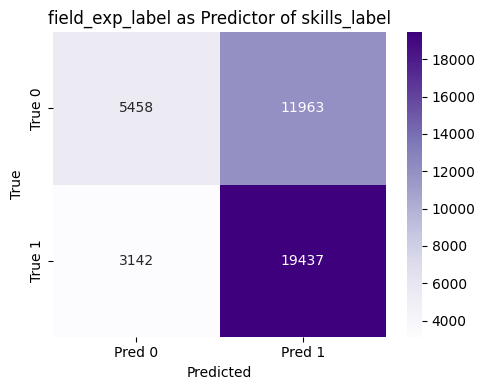


🔁 Evaluating skills_label as predictor of field_exp_label
              precision    recall  f1-score   support

           0       0.31      0.63      0.42      8600
           1       0.86      0.62      0.72     31400

    accuracy                           0.62     40000
   macro avg       0.59      0.63      0.57     40000
weighted avg       0.74      0.62      0.66     40000



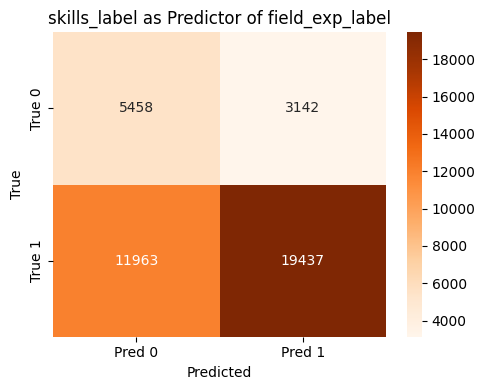

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the labeled dataset
df = pd.read_csv("labeled_data.csv")

# Ensure integer type
skills_label = df['skills_label'].astype(int)
field_label = df['field_exp_label'].astype(int)

# 1️⃣ Evaluate field_exp_label as prediction of skills_label
print("🔍 Evaluating field_exp_label as predictor of skills_label")
print(classification_report(skills_label, field_label))

conf_matrix_1 = confusion_matrix(skills_label, field_label)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("field_exp_label as Predictor of skills_label")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 2️⃣ Evaluate skills_label as predictor of field_exp_label
print("\n🔁 Evaluating skills_label as predictor of field_exp_label")
print(classification_report(field_label, skills_label))

conf_matrix_2 = confusion_matrix(field_label, skills_label)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("skills_label as Predictor of field_exp_label")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

انا هرتتتتتتتتتتترترقخه

🔍 Evaluating: Logistic Regression
              precision    recall  f1-score   support

           0       0.32      0.64      0.43      2607
           1       0.86      0.62      0.72      9393

    accuracy                           0.62     12000
   macro avg       0.59      0.63      0.57     12000
weighted avg       0.74      0.62      0.66     12000



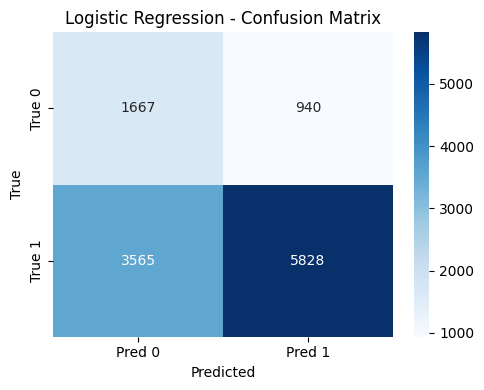


🔍 Evaluating: Decision Tree
              precision    recall  f1-score   support

           0       0.32      0.63      0.43      2607
           1       0.86      0.63      0.73      9393

    accuracy                           0.63     12000
   macro avg       0.59      0.63      0.58     12000
weighted avg       0.74      0.63      0.66     12000



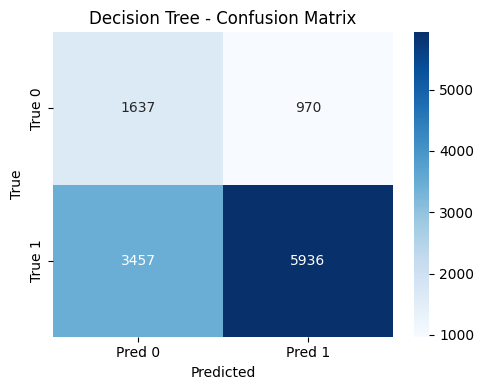


🔍 Evaluating: Random Forest
              precision    recall  f1-score   support

           0       0.32      0.62      0.42      2607
           1       0.86      0.64      0.73      9393

    accuracy                           0.63     12000
   macro avg       0.59      0.63      0.58     12000
weighted avg       0.74      0.63      0.67     12000



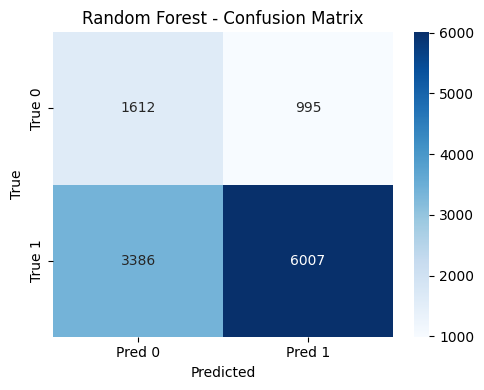


🔍 Evaluating: XGBoost
              precision    recall  f1-score   support

           0       0.32      0.63      0.43      2607
           1       0.86      0.63      0.73      9393

    accuracy                           0.63     12000
   macro avg       0.59      0.63      0.58     12000
weighted avg       0.74      0.63      0.66     12000



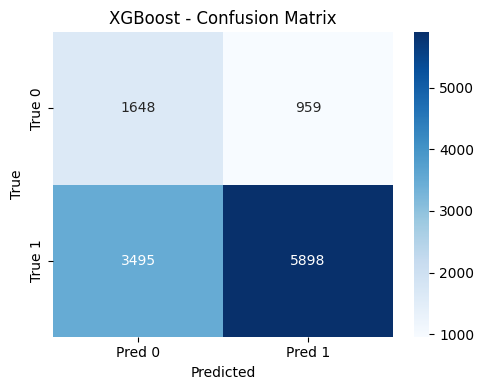

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
print('انا هرتتتتتتتتتتترترقخه')
# Load dataset
df = pd.read_csv("labeled_data.csv")

# Define features and label
X = df[['Experience_Score', 'normalized_skill_score']]
y = df['field_exp_label'].astype(int)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Compute scale_pos_weight for XGBoost
scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define models with class imbalance handling
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=scale, eval_metric='logloss')
}

# Train, predict, evaluate
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Classification Report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Save predictions to DataFrame (optional)
    df[f'{name}_pred'] = model.predict(df[['Experience_Score', 'normalized_skill_score']])



🔍 Tuning Logistic Regression...

Best Params for Logistic Regression: {'C': 10}
              precision    recall  f1-score   support

           0       0.32      0.64      0.43      2607
           1       0.86      0.62      0.72      9393

    accuracy                           0.62     12000
   macro avg       0.59      0.63      0.57     12000
weighted avg       0.74      0.62      0.66     12000



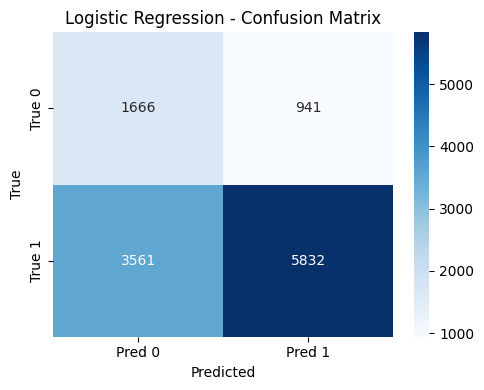


🔍 Tuning Decision Tree...

Best Params for Decision Tree: {'max_depth': 3, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.32      0.61      0.42      2607
           1       0.86      0.64      0.73      9393

    accuracy                           0.64     12000
   macro avg       0.59      0.63      0.58     12000
weighted avg       0.74      0.64      0.67     12000



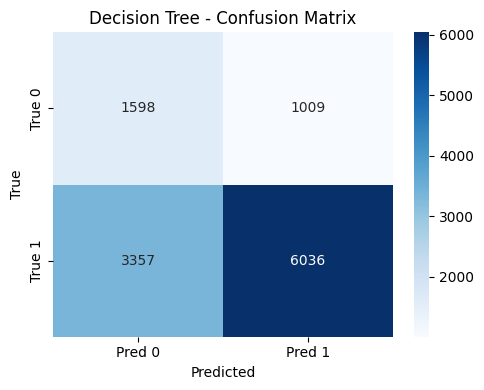


🔍 Tuning Random Forest...

Best Params for Random Forest: {'max_depth': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.32      0.63      0.43      2607
           1       0.86      0.63      0.73      9393

    accuracy                           0.63     12000
   macro avg       0.59      0.63      0.58     12000
weighted avg       0.74      0.63      0.66     12000



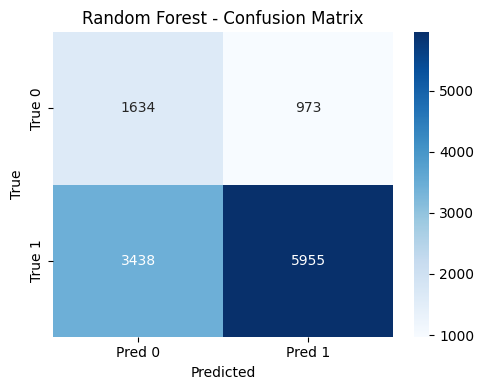


🔍 Tuning XGBoost...

Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.32      0.63      0.43      2607
           1       0.86      0.63      0.73      9393

    accuracy                           0.63     12000
   macro avg       0.59      0.63      0.58     12000
weighted avg       0.74      0.63      0.66     12000



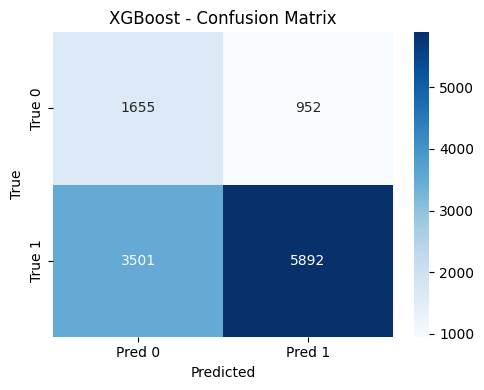

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("labeled_data.csv")
X = df[['Experience_Score', 'normalized_skill_score']]
y = df['field_exp_label'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Compute class imbalance scale
scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define models and parameter grids
param_grids = {
    "Logistic Regression": {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.1, 1, 10]
        }
    },
    "Decision Tree": {
        'model': DecisionTreeClassifier(class_weight='balanced'),
        'params': {
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 10]
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
        }
    },
    "XGBoost": {
        'model': XGBClassifier(scale_pos_weight=scale, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1]
        }
    }
}

# Run GridSearch for each model
best_models = {}

for name, config in param_grids.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    print(f"\nBest Params for {name}: {grid.best_params_}")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Optional: save predictions
    df[f'{name}_tuned_pred'] = best_model.predict(X)

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.64      0.43      2607
           1       0.86      0.62      0.72      9393

    accuracy                           0.62     12000
   macro avg       0.59      0.63      0.57     12000
weighted avg       0.74      0.62      0.65     12000



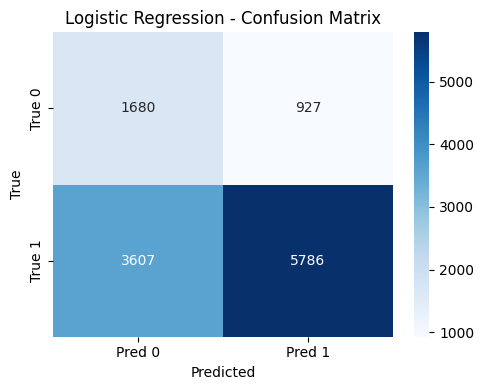

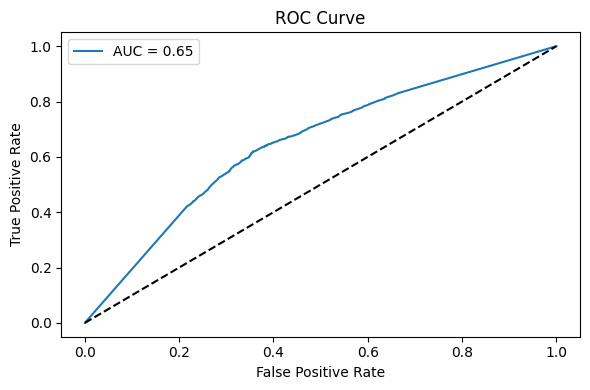

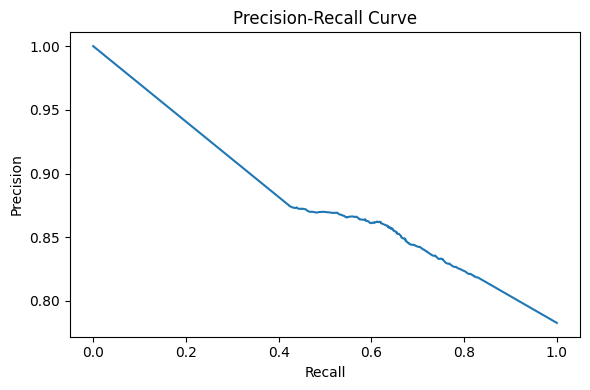

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

# Load your raw dataset
df = pd.read_csv("merged_data.csv")

# Step 1: Recreate the labels
df['skills_label'] = ((df['Experience_Score'] + df['normalized_skill_score']) / 2 >= 0.5).astype(int)
df['field_exp_label'] = (df['bert_field_similarity'] >= 0.085258).astype(int)

# Step 2: Add engineered features
df['exp_x_skill'] = df['Experience_Score'] * df['normalized_skill_score']
df['exp_squared'] = df['Experience_Score'] ** 2
df['skill_squared'] = df['normalized_skill_score'] ** 2

# Step 3: Define features and target
features = ['Experience_Score', 'normalized_skill_score', 'exp_x_skill', 'exp_squared', 'skill_squared']
X = df[features]
y = df['field_exp_label'].astype(int)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train logistic regression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Step 6: Evaluation
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

In [ ]:
# 🏷️ Create label
merged_df['label'] = (
    (merged_df['Experience_Score'] >= 0.5) &
    (merged_df['bert_field_similarity'] >= 0.3) &
    (merged_df['normalized_skill_score'] >= 0.2)
).astype(int)

# 🔍 Check imbalance
print("Label distribution:")
print(merged_df['label'].value_counts())

# ⚖️ Balance dataset by undersampling
df_0 = merged_df[merged_df['label'] == 0]
df_1 = merged_df[merged_df['label'] == 1]

if len(df_1) > 0:
    df_0_under = df_0.sample(n=len(df_1), random_state=42)
    df_balanced = pd.concat([df_0_under, df_1], axis=0).sample(frac=1, random_state=42)
else:
    print("No positive labels found! Using full dataset instead.")
    df_balanced = merged_df.copy()

# 🎯 Define features and labels
X = df_balanced[['Experience_Score', 'bert_field_similarity', 'normalized_skill_score']]
y = df_balanced['label']

# 🔀 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 📊 Train and evaluate each model
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score']
    })

# 📈 Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# 📉 Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Balanced Model Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.xticks(rotation=20)
plt.grid(True)
plt.show()

In [ ]:
# ✅ Smart combined score
merged_df['combined_score'] = (
    merged_df['Experience_Score'] * 0.3 +
    merged_df['bert_field_similarity'] * 0.5 +
    merged_df['normalized_skill_score'] * 0.2
)

# 🏷️ Label = top 20% of scores
threshold = merged_df['combined_score'].quantile(0.8)
merged_df['label'] = (merged_df['combined_score'] >= threshold).astype(int)

# ⚖️ Balance classes by undersampling
df_0 = merged_df[merged_df['label'] == 0]
df_1 = merged_df[merged_df['label'] == 1]
df_0_under = df_0.sample(n=len(df_1), random_state=42)
df_balanced = pd.concat([df_0_under, df_1]).sample(frac=1, random_state=42)

# 🧠 Stratified split by Job_Id
job_labels = df_balanced.groupby('Job_Id')['label'].max().reset_index()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(job_labels['Job_Id'], job_labels['label']):
    train_job_ids = job_labels.loc[train_idx, 'Job_Id']
    test_job_ids = job_labels.loc[test_idx, 'Job_Id']

train_df = df_balanced[df_balanced['Job_Id'].isin(train_job_ids)]
test_df = df_balanced[df_balanced['Job_Id'].isin(test_job_ids)]

# 🎯 Features & labels
X_train = train_df[['Experience_Score', 'bert_field_similarity', 'normalized_skill_score']]
y_train = train_df['label']
X_test = test_df[['Experience_Score', 'bert_field_similarity', 'normalized_skill_score']]
y_test = test_df['label']

# 🤖 Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 🔍 SHAP Explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 📈 Global SHAP Feature Importance
shap.plots.bar(shap_values, max_display=10, show=True)

In [ ]:
# 🔍 Predict again (if needed)
y_pred = model.predict(X_test)

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Match (0)", "Match (1)"])
disp.plot(cmap='Blues')
plt.title("Truth Table / Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
# Function to rank candidates per job by chosen weights
def rank_candidates(exp_w=0.3, field_w=0.4, skill_w=0.3):
    total = exp_w + field_w + skill_w
    exp_w, field_w, skill_w = exp_w/total, field_w/total, skill_w/total

    merged_df['final_score'] = (
        merged_df['Experience_Score'] * exp_w +
        merged_df['bert_field_similarity'] * field_w +
        merged_df['normalized_skill_score'] * skill_w
    )

    merged_df['rank'] = merged_df.groupby('Job_Id')['final_score'].rank(ascending=False, method='first')

    top_ranked = merged_df[merged_df['rank'] <= 5].sort_values(['Job_Id', 'final_score'], ascending=[True, False])

    display(top_ranked[['Job_Id', 'Candidate_Id', 'final_score', 'Experience_Score', 'bert_field_similarity', 'normalized_skill_score']].head(20))

# Interactive sliders for weight adjustment
interact(
    rank_candidates,
    exp_w=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.3, description='Experience'),
    field_w=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.4, description='Field Match'),
    skill_w=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.3, description='Skills')
)


In [ ]:
!pip install ipywidgets


In [ ]:
from google.colab import output

output.enable_custom_widget_manager()
# Custom ranking function
def custom_rank(include_exp=True, selected_features=['Field Match', 'Skills']):
    weights = {
        'Experience': 1 if include_exp else 0,
        'Field Match': 1 if 'Field Match' in selected_features else 0,
        'Skills': 1 if 'Skills' in selected_features else 0
    }
    total_weight = sum(weights.values())
    if total_weight == 0:
        print("Please select at least one feature to rank candidates.")
        return

    # Normalize weights
    weights = {k: v/total_weight for k, v in weights.items()}

    # Compute final score
    merged_df['final_score'] = (
        merged_df['Experience_Score'] * weights['Experience'] +
        merged_df['bert_field_similarity'] * weights['Field Match'] +
        merged_df['normalized_skill_score'] * weights['Skills']
    )

    # Rank candidates within each job
    merged_df['rank'] = merged_df.groupby('Job_Id')['final_score'].rank(ascending=False, method='first')

    # Show top 5 ranked candidates per job
    top_ranked = merged_df[merged_df['rank'] <= 5].sort_values(['Job_Id', 'final_score'], ascending=[True, False])

    display(top_ranked[['Job_Id', 'Candidate_Id', 'final_score', 'Experience_Score', 'bert_field_similarity', 'normalized_skill_score']].head(20))

# Show interactive widget
interact(
    custom_rank,
    include_exp=Checkbox(value=True, description='Include Experience'),
    selected_features=SelectMultiple(
        options=['Field Match', 'Skills'],
        value=['Field Match', 'Skills'],
        description='Features',
        disabled=False
    )
)


In [ ]:
!pip install ipywidgets
from google.colab import output
output.enable_custom_widget_manager()


In [ ]:

# Extract unique study fields
def extract_unique_fields(df, column='major_field_of_studies'):
    unique_fields = set()
    for val in df[column].dropna():
        try:
            items = ast.literal_eval(val)
            unique_fields.update(item.strip() for item in items)
        except:
            continue
    return sorted(unique_fields)

unique_fields = extract_unique_fields(new_df)

# Define widget
field_selector = SelectMultiple(
    options=unique_fields,
    value=['Computer Science'],
    description='Study Fields',
    layout={'width': '700px'}
)
export_button = Button(description="Download CSV", button_style='success')

# Define outputs
filtered_result = pd.DataFrame()

# Filter display function
def filter_and_display(fields):
    global filtered_result
    if not fields:
        print("Select at least one field.")
        return
    mask = new_df['major_field_of_studies'].apply(lambda x: any(f in str(x) for f in fields))
    filtered_result = new_df[mask]
    display(filtered_result[['skills', 'degree_names', 'major_field_of_studies', 'experiencere', 'positions', 'locations']])

# Export function
def export_csv(btn):
    if filtered_result.empty:
        print("Nothing to export.")
    else:
        path = "/content/filtered_cvs.csv"
        filtered_result.to_csv(path, index=False)
        print(f"✅ File saved: {path}")

# Bind actions
field_selector.observe(lambda change: filter_and_display(change['new']), names='value')
export_button.on_click(export_csv)

# Display everything
display(VBox([field_selector, export_button]))
filter_and_display(field_selector.value)


In [ ]:

# Extract unique fields
def extract_unique_fields(df, column='major_field_of_studies'):
    unique_fields = set()
    for val in df[column].dropna():
        try:
            items = ast.literal_eval(val)
            unique_fields.update(item.strip() for item in items)
        except:
            continue
    return sorted(unique_fields)

unique_fields = extract_unique_fields(new_df)

# Widgets
field_selector = SelectMultiple(
    options=unique_fields,
    value=['Computer Science'],
    description='Study Fields',
    layout={'width': '700px'}
)
export_button = Button(description="Download CSV", button_style='success')

# Global result
filtered_result = pd.DataFrame()

# Filter + sort by experience
def filter_and_display(fields):
    global filtered_result
    if not fields:
        print("Select at least one field.")
        return
    mask = new_df['major_field_of_studies'].apply(lambda x: any(f in str(x) for f in fields))
    filtered_result = new_df[mask].copy()
    filtered_result['experiencere'] = pd.to_numeric(filtered_result['experiencere'], errors='coerce')
    filtered_result = filtered_result.sort_values(by='experiencere', ascending=False)

    display(filtered_result[['experiencere', 'skills', 'degree_names', 'major_field_of_studies', 'positions', 'locations']])

# Export function
def export_csv(btn):
    if filtered_result.empty:
        print("Nothing to export.")
    else:
        path = "/content/filtered_sorted_by_exp.csv"
        filtered_result.to_csv(path, index=False)
        print(f"✅ File saved: {path}")

# Bind events
field_selector.observe(lambda change: filter_and_display(change['new']), names='value')
export_button.on_click(export_csv)

# Show
display(VBox([field_selector, export_button]))
filter_and_display(field_selector.value)


,experiencere,skills,degree_names,major_field_of_studies,positions,locations
659,48.0,NaN,[np.str_('MBA')],"['Computer Science', 'Computer Science']","['Professor Emerytus', 'Professor', 'Director ...",[np.str_('Lesotho')]
342,48.0,NaN,[np.str_('MBA')],"['Computer Science', 'Computer Science']","['Professor Emerytus', 'Professor', 'Director ...",[np.str_('Guatemala')]
3650,48.0,NaN,[np.str_('BBA')],"['Computer Science', 'Computer Science']","['Professor Emerytus', 'Professor', 'Director ...",[np.str_('Bulgaria')]
106,48.0,NaN,[np.str_('PhD')],"['Computer Science', 'Computer Science']","['Professor Emerytus', 'Professor', 'Director ...",[np.str_('Costa Rica')]
8446,48.0,NaN,[np.str_('MBA')],"['Computer Science', 'Computer Science']","['Professor Emerytus', 'Professor', 'Director ...",[np.str_('Angola')]
...,...,...,...,...,...,...
5257,4.0,Python Visual Studio Code Mercurial,[np.str_('BBA')],['Computer Science'],"['Mobile App Developer', 'Front-End Developer']",[np.str_('Lebanon')]
2359,4.0,JavaScript Visual Studio Code Git TensorFlow S...,[np.str_('MCA')],"['Computer Science', 'Computer Science']","['Technical Support', 'Office Assistant']",[np.str_('Eritrea')]
3274,4.0,Data Science Analysis Machine Learning Boundin...,[np.str_('BBA')],"['Computer Science Engineering', 'Data Science']",['Intern'],[np.str_('France')]
8705,4.0,Data Science Analysis Machine Learning Boundin...,[np.str_('M.Tech')],"['Computer Science Engineering', 'Data Science']",['Intern'],[np.str_('Comoros')]


,experiencere,skills,degree_names,major_field_of_studies,positions,locations
196,41.0,account reconciliation accounting accounts pay...,[np.str_('MBA')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Syrian Arab Republic')]
464,41.0,account reconciliation accounting accounts pay...,[np.str_('PhD')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Montenegro')]
469,41.0,account reconciliation accounting accounts pay...,[np.str_('M.Tech')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Bhutan')]
1415,41.0,account reconciliation accounting accounts pay...,[np.str_('PhD')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Turkmenistan')]
1833,41.0,account reconciliation accounting accounts pay...,[np.str_('BCA')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('France')]
2293,41.0,account reconciliation accounting accounts pay...,[np.str_('B.Tech')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Palau')]
2340,41.0,account reconciliation accounting accounts pay...,[np.str_('PhD')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Peru')]
2659,41.0,account reconciliation accounting accounts pay...,[np.str_('BA')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Honduras')]
3155,41.0,account reconciliation accounting accounts pay...,[np.str_('BA')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Djibouti')]
3537,41.0,account reconciliation accounting accounts pay...,[np.str_('M.Tech')],"['Accounting', 'Computer Programming in COBOL ...","['Accountant', 'Accountant', 'Staff Accountant...",[np.str_('Montenegro')]


In [ ]:
# Clean field list (YOUR LIST HERE)
field_options = [
    'General Studies', 'Computer Science, Web Development',
    'Computer Networks, Information Technology', 'Event Management, Hospitality',
    'Education', 'Design, Human-Computer Interaction',
    'Computer Science, Software Testing', 'Law', 'Mechanical Engineering',
    'Information Technology, Computer Networks',
    'Business Administration, Marketing', 'Marketing, Business Administration',
    'Social Work, Psychology', 'Marketing, Communication',
    'Marketing, Digital Communication', 'Human Resources',
    'Nursing, Medicine', 'Business Administration, Sales',
    'Computer Science, Software Engineering, Information Technology',
    'Supply Chain, Business Administration', 'Business, Marketing',
    'Civil Engineering, Construction Management',
    'Cybersecurity, Information Technology', 'Front-End Development, Design',
    'Finance, Accounting', 'Event Management', 'Psychology',
    'Electrical Engineering', 'Statistics, Mathematics, Economics',
    'Technical Communication, English', 'Accounting, Finance',
    'Business, Sales', 'Information Technology, Computer Science',
    'Computer Science, Database Systems', 'Statistics, Data Analysis',
    'Business Administration', 'Nursing', 'Finance, Economics',
    'Speech Pathology', 'Sales, Business Administration',
    'Landscape Architecture', 'Sales, Marketing',
    'Design Research, Psychology', 'Information Technology',
    'Fine Arts, Design', 'Software Engineering, Computer Science',
    'Project Management, Business Administration', 'Supply Chain, Business',
    'Psychology, Counseling', 'Supply Chain Management',
    'Computer Science, Data Engineering', 'Environmental Science',
    'Electrical Engineering, Electronics', 'Systems Engineering',
    'Fine Arts, Education', 'Supply Chain, Logistics',
    'Computer Science, Information Systems', 'Supply Chain',
    'Information Systems', 'English, Marketing', 'English, Journalism',
    'Computer Science, Software Engineering', 'Computer Science, Design',
    'Urban Planning', 'Architecture', 'Environmental Engineering',
    'Computer Science', 'Civil Engineering', 'Marketing, Statistics',
    'Business Administration, Information Systems', 'Chemistry',
    'Interior Design', 'Software Engineering', 'Veterinary Science',
    'Industrial Engineering', 'Quality Assurance, Software Testing',
    'Pharmacy, Sales', 'Medicine', 'Marketing',
    'Science, Research Methodology', 'Human Resources, Business Administration',
    'Public Relations', 'Finance', 'Aerospace Engineering',
    'Web Design', 'Occupational Therapy', 'Dentistry', 'Pediatrics',
    'Computer Science, Data Science, Statistics, Mathematics',
    'Graphic Design', 'Physical Therapy', 'Product Design',
    'Project Management', 'Sales', 'Chemical Engineering'
]
# Original combined fields list
field_options = [
    'General Studies', 'Computer Science, Web Development',
    'Computer Networks, Information Technology', 'Event Management, Hospitality',
    'Education', 'Design, Human-Computer Interaction',
    'Computer Science, Software Testing', 'Law', 'Mechanical Engineering',
    'Information Technology, Computer Networks',
    'Business Administration, Marketing', 'Marketing, Business Administration',
    'Social Work, Psychology', 'Marketing, Communication',
    'Marketing, Digital Communication', 'Human Resources',
    'Nursing, Medicine', 'Business Administration, Sales',
    'Computer Science, Software Engineering, Information Technology',
    'Supply Chain, Business Administration', 'Business, Marketing',
    'Civil Engineering, Construction Management',
    'Cybersecurity, Information Technology', 'Front-End Development, Design',
    'Finance, Accounting', 'Event Management', 'Psychology',
    'Electrical Engineering', 'Statistics, Mathematics, Economics',
    'Technical Communication, English', 'Accounting, Finance',
    'Business, Sales', 'Information Technology, Computer Science',
    'Computer Science, Database Systems', 'Statistics, Data Analysis',
    'Business Administration', 'Nursing', 'Finance, Economics',
    'Speech Pathology', 'Sales, Business Administration',
    'Landscape Architecture', 'Sales, Marketing',
    'Design Research, Psychology', 'Information Technology',
    'Fine Arts, Design', 'Software Engineering, Computer Science',
    'Project Management, Business Administration', 'Supply Chain, Business',
    'Psychology, Counseling', 'Supply Chain Management',
    'Computer Science, Data Engineering', 'Environmental Science',
    'Electrical Engineering, Electronics', 'Systems Engineering',
    'Fine Arts, Education', 'Supply Chain, Logistics',
    'Computer Science, Information Systems', 'Supply Chain',
    'Information Systems', 'English, Marketing', 'English, Journalism',
    'Computer Science, Software Engineering', 'Computer Science, Design',
    'Urban Planning', 'Architecture', 'Environmental Engineering',
    'Computer Science', 'Civil Engineering', 'Marketing, Statistics',
    'Business Administration, Information Systems', 'Chemistry',
    'Interior Design', 'Software Engineering', 'Veterinary Science',
    'Industrial Engineering', 'Quality Assurance, Software Testing',
    'Pharmacy, Sales', 'Medicine', 'Marketing',
    'Science, Research Methodology', 'Human Resources, Business Administration',
    'Public Relations', 'Finance', 'Aerospace Engineering',
    'Web Design', 'Occupational Therapy', 'Dentistry', 'Pediatrics',
    'Computer Science, Data Science, Statistics, Mathematics',
    'Graphic Design', 'Physical Therapy', 'Product Design',
    'Project Management', 'Sales', 'Chemical Engineering'
]


In [ ]:
new_df['Candidate_Id'] = new_df.index
merged_df = merged_df[merged_df['Candidate_Id'] < len(new_df)]
df_all = pd.merge(merged_df, new_df, on='Candidate_Id', how='left')
df_all = df_all.dropna(subset=['major_field_of_studies'])


# Split on commas, trim whitespace, deduplicate and sort
split_field_options = sorted(set(
    field.strip()
    for item in field_options
    for field in item.split(',')
))



# UI elements
include_exp = Checkbox(value=True, description="Include Experience?")
combo = Combobox(placeholder="Type to search fields...", options=split_field_options , description="Field:")
add_button = Button(description="Add Field", button_style='success')
clear_button = Button(description="Clear All", button_style='danger')
selected_output = Output()
result_output = Output()
selected_fields = []

# Display selected fields
def update_selected_display():
    with selected_output:
        clear_output()
        if selected_fields:
            print("🎯 Selected Fields (X OR Y):")
            for field in selected_fields:
                print("•", field)
        else:
            print("No fields selected yet.")

# Add field to list
def on_add_clicked(_):
    val = combo.value
    if val and val in field_options and val not in selected_fields:
        selected_fields.append(val)
        update_selected_display()
        display_results()

# Clear selection
def on_clear_clicked(_):
    selected_fields.clear()
    update_selected_display()
    with result_output:
        clear_output()

# Check for any match (X OR Y) from selected fields
def field_match(x):
    try:
        fields = ast.literal_eval(x)
        return any(f in fields for f in selected_fields)
    except:
        return False

# Display top candidates
def display_results():
    with result_output:
        clear_output()

        if not selected_fields:
            print("⚠️ Please select at least one field.")
            return

        # Use corrected field matching
        mask = df_all['major_field_of_studies'].apply(field_match)
        filtered = df_all[mask].copy()

        if filtered.empty:
            print("😕 No matching candidates.")
            return

        # Weights based on experience inclusion
        exp_w, field_w, skill_w = (0.3, 0.5, 0.2) if include_exp.value else (0.0, 0.5, 0.2)
        total = exp_w + field_w + skill_w
        exp_w, field_w, skill_w = exp_w/total, field_w/total, skill_w/total

        # Compute final score
        filtered['final_score'] = (
            filtered['Experience_Score'] * exp_w +
            filtered['bert_field_similarity'] * field_w +
            filtered['normalized_skill_score'] * skill_w
        )

        # Top 20 sorted
        top20 = filtered.sort_values(by='final_score', ascending=False).head(20)
        display(top20[['Candidate_Id', 'final_score', 'Experience_Score', 'bert_field_similarity', 'normalized_skill_score', 'major_field_of_studies']])

# Bind buttons
add_button.on_click(on_add_clicked)
clear_button.on_click(on_clear_clicked)
include_exp.observe(lambda _: display_results(), names='value')

# Show UI
update_selected_display()
display(VBox([
    include_exp,
    HBox([combo, add_button, clear_button]),
    selected_output,
    result_output
]))


TypeError: '<' not supported between instances of 'str' and 'int'